In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from math import ceil

import warnings
#warnings.filterwarnings("ignore")

from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from random import randint

In [2]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

In [3]:
df_train = pd.read_csv("df_train_processed.csv")

In [4]:
df_train = df_train.drop(columns=['actor'])

In [5]:
df_train['emotional_intensity'].value_counts()

normal    984
strong    844
Name: emotional_intensity, dtype: int64

## Standardization

In [6]:
df_train_num = df_train.select_dtypes(include="number")
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [7]:
df_train_model = df_train

In [8]:
label_encoder = preprocessing.LabelEncoder()
df_train_model['emotional_intensity']= label_encoder.fit_transform(df_train_model['emotional_intensity'])

In [9]:
df_train_model = pd.get_dummies(df_train_model)

In [10]:
df_emotional_intensity_train = df_train_model

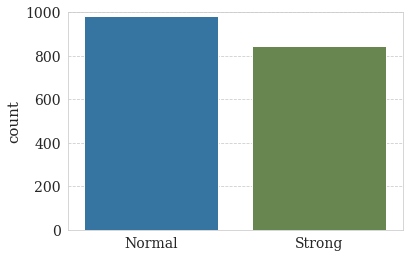

In [11]:
labels = ['Normal','Strong']
ax=sns.countplot(x=df_emotional_intensity_train['emotional_intensity'], palette=['#2478b4','#678F46'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim([0, 1000])
img_name = 'Before_Imbalancing_Emotional_Intensity' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [12]:
X = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns != 'emotional_intensity'])
    
y = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns == 'emotional_intensity'])

In [13]:
np.unique(y, return_counts=True)

(array([0, 1]), array([984, 844]))

In [14]:
import random
random.seed(2)
rows2remove = np.random.choice(df_emotional_intensity_train[y == 0].index, 984-35, replace=False)

In [15]:
df2 = df_emotional_intensity_train.drop(index=rows2remove, axis=0)
print(len(df2))

879


In [16]:
X2 = np.array(df2.loc[:, df2.columns != 'emotional_intensity'])
y2 = np.array([y[i] for i in range(len(y)) if i not in rows2remove]).ravel()

In [17]:
np.unique(y2, return_counts=True)        

(array([0, 1]), array([ 35, 844]))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=100)

In [19]:
X_train.shape

(615, 392)

## Decision Tree before Undersampling/Oversampling

In [20]:
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import RepeatedStratifiedKFold

In [21]:
def Decision_tree(X_train_array, y_train_array):
    
    
    param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"],
    
}


    tree = DecisionTreeClassifier(random_state=42)


    tree_cv = RandomizedSearchCV(tree, param_grid, cv=RepeatedStratifiedKFold(n_splits=5,random_state=42),
    n_jobs=-1,
    n_iter=200)


    tree_cv.fit(X_train_array,y_train_array)

    return tree_cv

In [22]:
decision_tree = Decision_tree(X_train, y_train)

In [23]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 160, 'min_samples_leaf': 0.028492648825420352, 'min_samples_split': 0.9439946316125913}


In [24]:
model_tree = decision_tree.best_estimator_
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=160,
                       min_samples_leaf=0.028492648825420352,
                       min_samples_split=0.9439946316125913, random_state=42)

In [25]:
y_pred_decision_tree = model_tree.predict(X_test)

In [26]:
def metrics_model( test,predict, majority_class, minority_class):
    new_dic = {}
    new_dic['accuracy'] = accuracy_score(test,predict)
    #new_dic['precision ('+ majority_class + ')'] = precision_score(predict, test, average=None)[0]
    #new_dic['precision ('+ minority_class + ')'] = precision_score(predict, test,average=None)[1]
    #new_dic['recall ('+ majority_class + ')'] = recall_score(predict, test, average=None)[0]
    #new_dic['recall ('+ minority_class + ')'] = recall_score(predict, test, average=None)[1]
    new_dic['f1_score ('+ majority_class + ')'] = f1_score(test,predict, average=None)[0]
    new_dic['f1_score ('+ minority_class + ')'] = f1_score(test,predict, average=None)[1]
    
    return new_dic

In [27]:
data_decision_tree = metrics_model( y_test, y_pred_decision_tree, 'normal', 'strong')
data_decision_tree

{'accuracy': 0.9431818181818182,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.9707602339181286}

In [28]:
print(classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.94      1.00      0.97       249

    accuracy                           0.94       264
   macro avg       0.47      0.50      0.49       264
weighted avg       0.89      0.94      0.92       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

## KNN before Undersampling/Oversampling

In [29]:
def spearman_selector(target, df, k):
    """Returns a df comprising all the features highly correlated (above k and below -k)
    with the binary target according Spearman coefficient. Target must be a pd Series"""
    df = df.select_dtypes(include="number")
    target = target.map({target.unique()[0]:0, target.unique()[1]:1})
    new_df = pd.DataFrame()
    for col in df:
        spearman = stats.spearmanr(df[col], target)[0]
        if spearman > k or spearman < -k:
            new_df[col] = df[col]
    return new_df

In [30]:
df_emotional_intensity_train_knn = spearman_selector(df_train['emotional_intensity'], 
                                           df_train, 0.4)

/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [31]:
df_train_cat_knn = df_train.select_dtypes(include=['object'])
df_emotional_intensity_train = pd.concat([df_emotional_intensity_train_knn, df_train_cat_knn], axis=1)

In [32]:
df_emotional_intensity_train = pd.get_dummies(df_emotional_intensity_train)

In [33]:
X3 = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns != 'emotional_intensity'])
    
y3 = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns == 'emotional_intensity'])

In [34]:
np.unique(y3, return_counts=True)

(array([0, 1]), array([984, 844]))

In [35]:
import random
random.seed(2)
rows2remove1 = np.random.choice(df_emotional_intensity_train[y == 0].index, 984-35, replace=False)

In [36]:
df3 = df_emotional_intensity_train.drop(index=rows2remove1, axis=0)
print(len(df3))

879


In [37]:
X4 = np.array(df3.loc[:, df3.columns != 'emotional_intensity'])
y4 = np.array([y[i] for i in range(len(y)) if i not in rows2remove1]).ravel()

In [38]:
np.unique(y4, return_counts=True)   

(array([0, 1]), array([ 35, 844]))

In [39]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X4, y4, test_size=0.3, random_state=100)

In [40]:
X_train_knn.shape

(615, 21)

In [41]:
def Knn(X_train_array, y_train_array):  
    
    knn = KNeighborsClassifier()
    
    parameters = {
        'n_neighbors': np.arange(2, X_train_array.shape[0]//2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'cityblock', 'minkowski']
        }
    
    knn_cv = RandomizedSearchCV(knn,
                     parameters,
                    cv=RepeatedStratifiedKFold(n_splits=5,random_state=42),
                    n_jobs=-1,
                    refit=True,random_state=24)
    
    knn_cv.fit(X_train_array, y_train_array)
    
    return knn_cv

In [42]:
knn = Knn(X_train_knn, y_train_knn)

In [43]:
print(knn.best_params_)

{'weights': 'uniform', 'n_neighbors': 211, 'metric': 'euclidean'}


In [44]:
model_knn = knn.best_estimator_
model_knn.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(metric='euclidean', n_neighbors=211)

In [45]:
y_pred_knn = model_knn.predict(X_test_knn)

In [46]:
data_knn = metrics_model(y_test_knn, y_pred_knn, 'normal', 'strong')
data_knn

{'accuracy': 0.9507575757575758,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.9747572815533981}

In [47]:
print(classification_report(y_test_knn, y_pred_knn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.95      1.00      0.97       251

    accuracy                           0.95       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.90      0.95      0.93       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [48]:
def combined_results(data,data1):
    combined_dic = {'Decision_tree': data, 'Knn':data1}
    
    return combined_dic

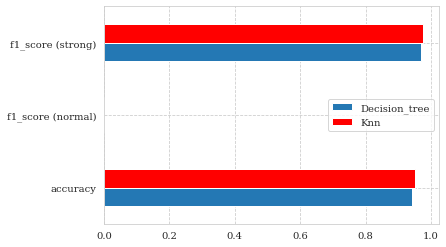

In [49]:
combined_dic = combined_results(data_decision_tree,data_knn)
df = pd.DataFrame(combined_dic)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('Imbalanced_Emotional_Intensity_Result',dpi=300, bbox_inches='tight')
plt.show()

## Undersampling

## Random Undersampling

In [50]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours

In [51]:
acc_knn = []
f1_score_knn_normal = []
f1_score_knn_strong = []

for i in range(10):
    rus = RandomUnderSampler()
    X_res_rus_knn, y_res_rus_knn = rus.fit_resample(X_train_knn, y_train_knn)
    
    # train a classifier on the balanced training set
    knn_under_rus = Knn(X_res_rus_knn, y_res_rus_knn)
    knn_best = knn_under_rus.best_estimator_
    
    knn_best.fit(X_res_rus_knn, y_res_rus_knn)
    
    # evaluate the classifier on the test set
    y_pred = knn_best.predict(X_test_knn)
    f1_score_knn = metrics.f1_score(y_test_knn, y_pred, average=None)
    acc = accuracy_score(y_test_knn, y_pred)
    acc_knn.append(acc)
    f1_score_knn_normal.append(f1_score_knn[0])
    f1_score_knn_strong.append(f1_score_knn[1])

In [52]:
knn_rus = {}
knn_rus['accuracy'] = sum(acc_knn)/len(acc_knn)
knn_rus['f1_score (normal)'] = sum(f1_score_knn_normal)/len(f1_score_knn_normal)
knn_rus['f1_score (strong)'] = sum(f1_score_knn_strong)/len(f1_score_knn_strong)
print(knn_rus)

{'accuracy': 0.5897727272727271, 'f1_score (normal)': 0.12986827233250958, 'f1_score (strong)': 0.7289807502629465}


In [53]:
acc_dt = []
f1_score_dt_normal = []
f1_score_dt_strong = []

for i in range(10):
    rus = RandomUnderSampler()
    X_rus, y_rus = rus.fit_resample(X_train, y_train)
    
    # train a classifier on the balanced training set
    dt_under_rus = Decision_tree(X_rus, y_rus)
    dt_best = dt_under_rus.best_estimator_
    
    dt_best.fit(X_rus, y_rus)
    
    # evaluate the classifier on the test set
    y_pred_dt = dt_best.predict(X_test)
    f1_score_dt = metrics.f1_score(y_test, y_pred_dt, average=None)
    acc = accuracy_score(y_test, y_pred_dt)
    acc_dt.append(acc)
    f1_score_dt_normal.append(f1_score_dt[0])
    f1_score_dt_strong.append(f1_score_dt[1])

In [54]:
dt_rus = {}
dt_rus['accuracy'] = sum(acc_dt)/len(acc_dt)
dt_rus['f1_score (normal)'] = sum(f1_score_dt_normal)/len(f1_score_dt_normal)
dt_rus['f1_score (strong)'] = sum(f1_score_dt_strong)/len(f1_score_dt_strong)
print(dt_rus)

{'accuracy': 0.5140151515151515, 'f1_score (normal)': 0.17567025418513368, 'f1_score (strong)': 0.6516941367979074}


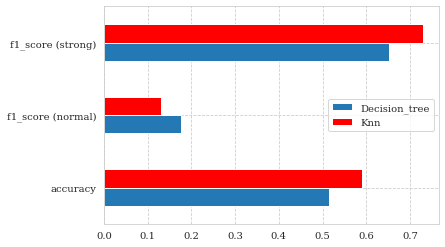

In [55]:
combined_dic_rus = combined_results(dt_rus,knn_rus)
df = pd.DataFrame(combined_dic_rus)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.legend('loc=l', bbox_to_anchor=(0.6,0.5), labels=['Decision Tree', 'KNN'])
#plt.savefig('RandomUndersampling_Emotional_Intensity_Result',dpi=300, bbox_inches='tight')
plt.show()

## Edited Nearest Neighbors

In [56]:
def enn(X_train_array, y_train_array):
    
    enn = EditedNearestNeighbours()
    
    X_res_enn, y_res_enn = enn.fit_resample(X_train_array, y_train_array)
    
    return X_res_enn, y_res_enn

In [57]:
X_res_enn, y_res_enn = enn(X_train, y_train)

In [58]:
X_res_enn_knn, y_res_enn_knn = enn(X_train_knn, y_train_knn)

In [59]:
print('Resampled dataset shape %s' % Counter(y_res_enn))

Resampled dataset shape Counter({1: 548, 0: 20})


## KNN after Edited Nearest Neighbors

In [60]:
knn_under_enn = Knn(X_res_enn_knn, y_res_enn_knn)

In [61]:
print(knn_under_enn.best_params_)

{'weights': 'uniform', 'n_neighbors': 211, 'metric': 'euclidean'}


In [62]:
model_knn_enn = knn_under_enn.best_estimator_
model_knn_enn.fit(X_res_enn_knn, y_res_enn_knn)

KNeighborsClassifier(metric='euclidean', n_neighbors=211)

In [63]:
y_pred_knn_under_enn = model_knn_enn.predict(X_test_knn)

In [64]:
knn_enn = metrics_model(y_test_knn,y_pred_knn_under_enn, 'normal', 'strong')
knn_enn

{'accuracy': 0.9507575757575758,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.9747572815533981}

In [65]:
print(classification_report(y_test_knn, y_pred_knn_under_enn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.95      1.00      0.97       251

    accuracy                           0.95       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.90      0.95      0.93       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

## Decision Tree after Edited Nearest Neighbors

In [66]:
decision_tree_under_enn = Decision_tree(X_res_enn, y_res_enn)

In [67]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_enn.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 58, 'min_samples_leaf': 0.10184629927631324, 'min_samples_split': 0.7054539021879677}


In [68]:
model_tree_enn = decision_tree_under_enn.best_estimator_
model_tree_enn.fit(X_res_enn, y_res_enn)

DecisionTreeClassifier(max_depth=58, min_samples_leaf=0.10184629927631324,
                       min_samples_split=0.7054539021879677, random_state=42)

In [69]:
y_pred_decision_tree_under_enn = model_tree_enn.predict(X_test)

In [70]:
decision_tree_enn = metrics_model(y_test, y_pred_decision_tree_under_enn, 'strong', 'normal')
decision_tree_enn

{'accuracy': 0.9431818181818182,
 'f1_score (strong)': 0.0,
 'f1_score (normal)': 0.9707602339181286}

In [71]:
print(classification_report(y_test, y_pred_decision_tree_under_enn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.94      1.00      0.97       249

    accuracy                           0.94       264
   macro avg       0.47      0.50      0.49       264
weighted avg       0.89      0.94      0.92       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

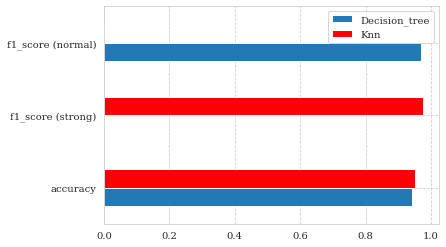

In [72]:
combined_dic_enn = combined_results(decision_tree_enn,knn_enn)
df = pd.DataFrame(combined_dic_enn)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('dddd',dpi=300, bbox_inches='tight')
plt.show()

## Oversampling

## SMOTE

In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
def smote(X_train_array, y_train_array):
    
    sm = SMOTE(random_state=42)
    
    X_res_sm, y_res_sm = sm.fit_resample(X_train_array, y_train_array)
    
    return X_res_sm, y_res_sm

In [75]:
X_res_sm_knn, y_res_sm_knn = smote(X_train_knn, y_train_knn)

In [76]:
X_res_sm, y_res_sm = smote(X_train, y_train)

In [77]:
print('Resampled dataset shape %s' % Counter(y_res_sm))

Resampled dataset shape Counter({1: 595, 0: 595})


## KNN after SMOTE

In [78]:
knn_over_sm = Knn(X_res_sm_knn, y_res_sm_knn)

In [79]:
print(knn_over_sm.best_params_)

{'weights': 'distance', 'n_neighbors': 507, 'metric': 'cityblock'}


In [80]:
model_knn_smote = knn_over_sm.best_estimator_
model_knn_smote.fit(X_res_sm_knn, y_res_sm_knn)

KNeighborsClassifier(metric='cityblock', n_neighbors=507, weights='distance')

In [81]:
y_pred_knn_over_sm = model_knn_smote.predict(X_test_knn)

In [82]:
knn_smote = metrics_model(y_test_knn, y_pred_knn_over_sm, 'normal', 'strong')
knn_smote

{'accuracy': 0.7840909090909091,
 'f1_score (normal)': 0.19718309859154928,
 'f1_score (strong)': 0.87527352297593}

In [83]:
print(classification_report(y_test_knn, y_pred_knn_over_sm))

              precision    recall  f1-score   support

           0       0.12      0.54      0.20        13
           1       0.97      0.80      0.88       251

    accuracy                           0.78       264
   macro avg       0.55      0.67      0.54       264
weighted avg       0.93      0.78      0.84       264



## Decision Tree after SMOTE

In [84]:
decision_tree_over_sm = Decision_tree(X_res_sm, y_res_sm)

In [85]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_over_sm.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'log_loss', 'max_depth': 136, 'min_samples_leaf': 0.0016354286478978512, 'min_samples_split': 0.02056831928915016}


In [86]:
model_tree_smote = decision_tree_over_sm.best_estimator_
model_tree_smote.fit(X_res_sm, y_res_sm)

DecisionTreeClassifier(criterion='log_loss', max_depth=136,
                       min_samples_leaf=0.0016354286478978512,
                       min_samples_split=0.02056831928915016, random_state=42)

In [87]:
y_pred_decision_tree_over_sm = model_tree_smote.predict(X_test)

In [88]:
decision_tree_smote = metrics_model(y_test, y_pred_decision_tree_over_sm, 'strong', 'normal')
decision_tree_smote

{'accuracy': 0.8901515151515151,
 'f1_score (strong)': 0.17142857142857143,
 'f1_score (normal)': 0.9411764705882353}

In [89]:
print(classification_report(y_test, y_pred_decision_tree_over_sm))

              precision    recall  f1-score   support

           0       0.15      0.20      0.17        15
           1       0.95      0.93      0.94       249

    accuracy                           0.89       264
   macro avg       0.55      0.57      0.56       264
weighted avg       0.91      0.89      0.90       264



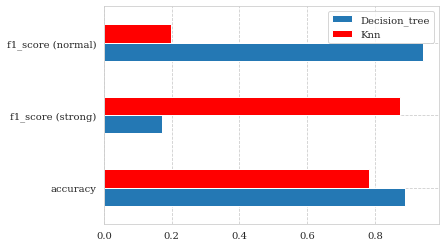

In [90]:
combined_dic_smote = combined_results(decision_tree_smote,knn_smote)
df = pd.DataFrame(combined_dic_smote)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.legend('loc=l', bbox_to_anchor=(0.6,0.5), labels=['Decision Tree', 'KNN'])
plt.savefig('SMOTE_Emotional_Intensity_Result',dpi=300, bbox_inches='tight')
plt.show()

## Decision Tree with class weight

In [91]:
def Decision_tree_cw(X_train_array, y_train_array):
    
    param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": list(range(2,200)),
    "criterion": ["gini", "entropy", "log_loss"],
    
}


    tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')


    tree_cv = RandomizedSearchCV(tree, 
                                 param_grid, 
                                 cv=RepeatedStratifiedKFold(n_splits=5,random_state=42),
                                 n_jobs=-1,
                                 n_iter=200, 
                                 error_score='raise')


    tree_cv.fit(X_train_array,y_train_array)

    return tree_cv

In [92]:
decision_tree_cl = Decision_tree_cw(X_train, y_train)

In [93]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_cl.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 83, 'min_samples_leaf': 0.00417086495628287, 'min_samples_split': 0.012784712855260673}


In [94]:
model_tree_cl = decision_tree_cl.best_estimator_
model_tree_cl.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=83,
                       min_samples_leaf=0.00417086495628287,
                       min_samples_split=0.012784712855260673, random_state=42)

In [95]:
y_pred_decision_tree_cl = model_tree_cl.predict(X_test)

In [96]:
decision_tree_cl = metrics_model(y_test, y_pred_decision_tree_cl, 'normal', 'strong')
decision_tree_cl

{'accuracy': 0.8901515151515151,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.9418837675350701}

In [97]:
print(classification_report(y_test, y_pred_decision_tree_cl))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.94      0.94      0.94       249

    accuracy                           0.89       264
   macro avg       0.47      0.47      0.47       264
weighted avg       0.89      0.89      0.89       264



In [116]:
def combined_results_final_knn(data,  data2, data3):
    
    combined_dic = {'Before Balancing': data, 
                   'Random Undersampling': data2,
                   'SMOTE': data3}
    
    return combined_dic

In [117]:
def combined_results_final_dt(data,  data2, data3,data4):
    
    combined_dic = {'Before Balancing': data, 
                   'Random Undersampling': data2,
                   'SMOTE': data3,
                   'Class Balanced': data4}
    
    return combined_dic

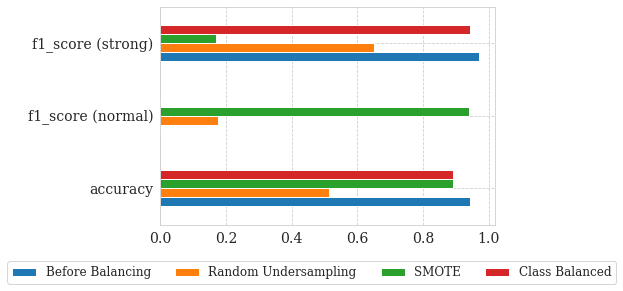

In [118]:
combined_dic_dt = combined_results_final_dt(data_decision_tree,  dt_rus, decision_tree_smote,decision_tree_cl)
df = pd.DataFrame(combined_dic_dt)
ax = df.plot(kind='barh')
ax.legend(loc='lower right', bbox_to_anchor=(1.38,-0.3),prop={'size': 12},ncol=4)
ax.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('Decision_Tree_Result_EI',dpi=300, bbox_inches='tight')
plt.show()

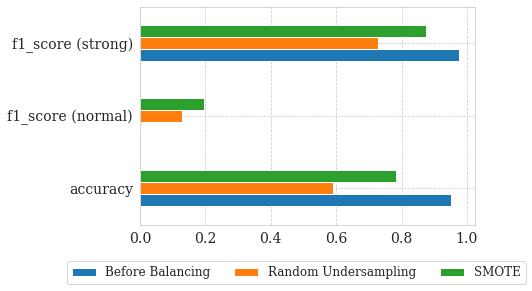

In [119]:
combined_dic_knn = combined_results_final_knn(data_knn,  knn_rus, knn_smote)
df = pd.DataFrame(combined_dic_knn)
ax = df.plot(kind='barh')
ax.legend(loc='lower right', bbox_to_anchor=(1.17,-0.3),prop={'size': 12},ncol=3)
ax.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('KNN_Result_EI',dpi=300, bbox_inches='tight')
plt.show()